# Introduction

For this notebook we will be addressing the technological and educational differences between data scientists and other kinds of developers. Only the data from 2020 Stack Overflow Survey will be used. The dataset will be filtered by selecting only the respodents that at least code as part of their work and also are effectivly employed.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import os

sns.set(context='notebook', style='whitegrid', font_scale=1)

## Loading and filtering data

In [2]:
# loading the data selecting only columns related to 
# tecnolohical competencies or educational level and
# columns used for filtering and comparing results
# such as 'MainBranch', 'Employment' and 'DevType'
# also, respondent is loaded and used as the table index
data_folder = 'data'
file_path = os.path.join(data_folder, '2020_data.zip')

cols = ['Respondent', 'MainBranch', 'Employment', 'DevType',
        'UndergradMajor', 'EdLevel',
        'DatabaseDesireNextYear', 'DatabaseWorkedWith',
        'LanguageDesireNextYear', 'LanguageWorkedWith',
        'MiscTechDesireNextYear', 'MiscTechWorkedWith']

df = pd.read_csv(file_path, index_col='Respondent', usecols=cols)
df.head()

,MainBranch,DatabaseDesireNextYear,DatabaseWorkedWith,DevType,EdLevel,Employment,LanguageDesireNextYear,LanguageWorkedWith,MiscTechDesireNextYear,MiscTechWorkedWith,UndergradMajor
Respondent,,,,,,,,,,,
1,I am a developer by profession,Microsoft SQL Server,Elasticsearch;Microsoft SQL Server;Oracle,"Developer, desktop or enterprise applications;...","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...",C#;HTML/CSS;JavaScript,C#;HTML/CSS;JavaScript,.NET Core;Xamarin,.NET;.NET Core,"Computer science, computer engineering, or sof..."
2,I am a developer by profession,NaN,NaN,"Developer, full-stack;Developer, mobile","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,Python;Swift,JavaScript;Swift,React Native;TensorFlow;Unity 3D,React Native,"Computer science, computer engineering, or sof..."
3,I code primarily as a hobby,NaN,NaN,NaN,NaN,NaN,Objective-C;Python;Swift,Objective-C;Python;Swift,NaN,NaN,NaN
4,I am a developer by profession,NaN,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",NaN,NaN,NaN,NaN,NaN,"Computer science, computer engineering, or sof..."
5,"I used to be a developer by profession, but no...",MySQL;PostgreSQL,MySQL;PostgreSQL;Redis;SQLite,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,Java;Ruby;Scala,HTML/CSS;Ruby;SQL,Ansible;Chef,Ansible,"Computer science, computer engineering, or sof..."


In [3]:
# filtering the data

# professional coder filtering condition
professional_coder_options = ['I am a developer by profession',
                              'I am not primarily a developer, but I write code sometimes as part of my work']
professional_coders = df['MainBranch'].isin(professional_coder_options)

# empployed filtering conddition
employed_options = ['Independent contractor, freelancer, or self-employed',
                    'Employed full-time', 'Employed part-time']
employed = df['Employment'].isin(employed_options)

# both conditions
employed_coders = employed & professional_coders

# viewng the percentage of results
print(f'Percentual selecionado: {employed_coders.mean():.2%}')

# filtering original data
df = df[employed_coders].copy()

Percentual selecionado: 77.54%


# Data Scientists

After filtering the data we must segment our data between data scients and all the other developer types. First lets take a look at the distribution of developer types. It is important to keep in mind that since it was possible to answer more than one type, the total sum of the percentages can be (and is) more than 100%.

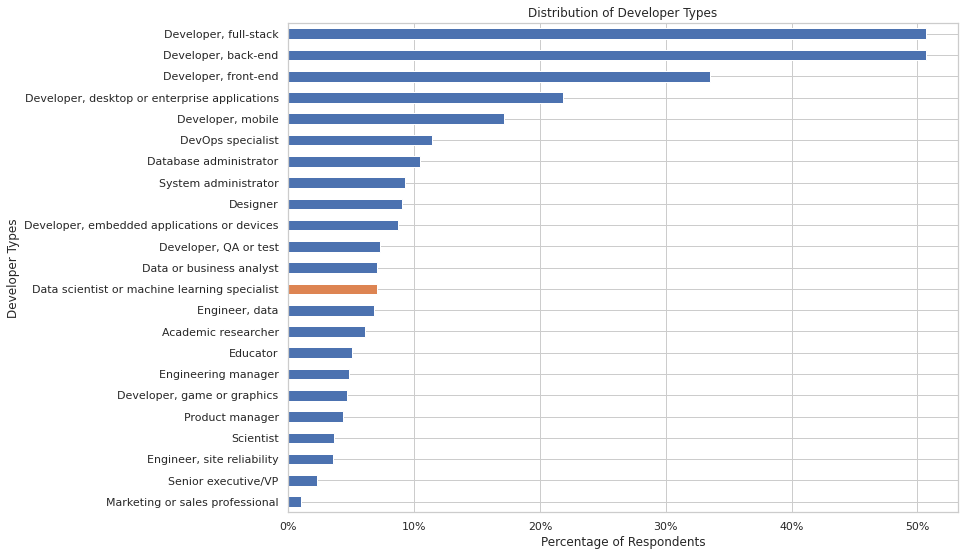

In [4]:
devtype_distr = df['DevType'].str.split(';').explode().dropna().value_counts().div(df.shape[0])

diff_index = 'Data scientist or machine learning specialist'
palette = sns.color_palette()
colors = [palette[1] if i == diff_index else palette[0] for i in devtype_distr.index]

ax = devtype_distr.plot(kind='barh', figsize=(12, 9), color=colors)
plt.gca().invert_yaxis()
ax.xaxis.set_major_formatter(lambda x, p: f'{x:.0%}')
plt.ylabel('Developer Types')
plt.xlabel('Percentage of Respondents')
plt.title('Distribution of Developer Types')
plt.show()

In [5]:
df['DataScience'] = df['DevType'].str.contains('Data scientist or machine learning specialist')
df['DataScience'].fillna(False, inplace=True)
print(f'Percents of devs that are Data Scientists: {df["DataScience"].mean():.2%} ({df["DataScience"].sum()})')

Percents of devs that are Data Scientists: 7.06% (3529)


As expected the great majority of respondents are developers. Only about 7% work as data scientists. 

# Comparisons

In [6]:
def compute_cat_dist(cat_data: pd.Series, multi: bool) -> pd.Series:
    cat_data.dropna(inplace=True)
    size = cat_data.shape[0]
    
    if multi:
        cat_data = cat_data.str.split(';').explode()
    
    return cat_data.value_counts().div(size)

In [7]:
def comparing_categoricals(data: pd.DataFrame, cat_var: str, multi=True):
    """This function is used to compare the distribution of categorical
    varable between the respondents tha are datascients with the other ones.
    This function works with multi category answers as well as single category ones.
    """
    
    # segmenting the data
    ds_cat_data = data.loc[data['DataScience'], cat_var].copy()
    ds_cat_dist = compute_cat_dist(ds_cat_data, multi).to_frame('Data Scientists')
    
    ot_cat_data = data.loc[~data['DataScience'], cat_var].copy()
    ot_cat_dist = compute_cat_dist(ot_cat_data, multi).rename('Others')
    
    cat_dist = ds_cat_dist.join(ot_cat_dist)
    cat_dist['Diff'] = cat_dist['Data Scientists'] - cat_dist['Others']
    return cat_dist

## Undergraduate Majors

In [8]:
undergrad_compare = comparing_categoricals(df, 'UndergradMajor', False)
undergrad_compare.mul(100).round(2).sort_values(by='Diff', ascending=False)

,Data Scientists,Others,Diff
Mathematics or statistics,12.35,2.83,9.52
"A natural science (such as biology, chemistry, physics, etc.)",10.73,3.80,6.93
"Another engineering discipline (such as civil, electrical, mechanical, etc.)",11.93,9.12,2.81
"A social science (such as anthropology, psychology, political science, etc.)",3.51,1.64,1.87
"A health science (such as nursing, pharmacy, radiology, etc.)",0.69,0.35,0.34
"A business discipline (such as accounting, finance, marketing, etc.)",2.85,2.58,0.27
I never declared a major,0.27,0.74,-0.47
"A humanities discipline (such as literature, history, philosophy, etc.)",1.32,2.09,-0.77
"Fine arts or performing arts (such as graphic design, music, studio art, etc.)",0.42,1.54,-1.12
Web development or web design,0.69,3.45,-2.76


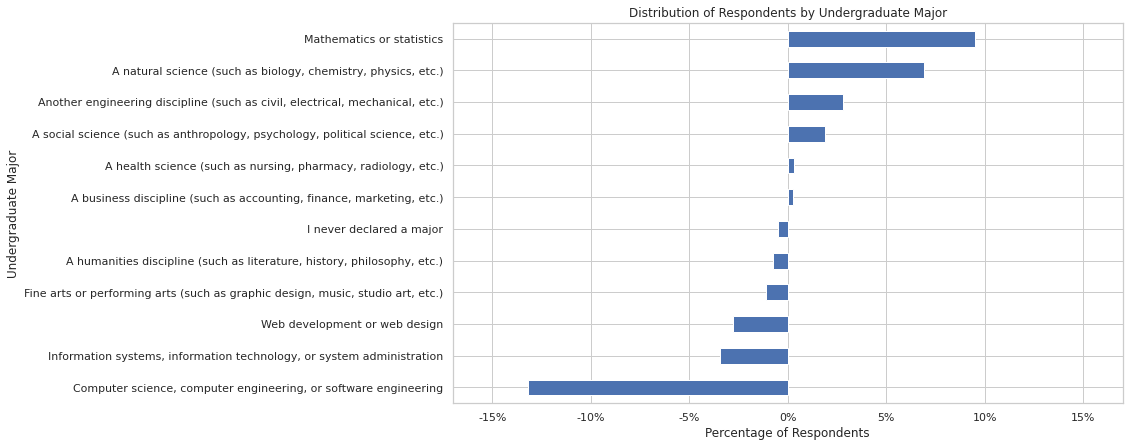

In [9]:
diffs = undergrad_compare['Diff']
ax = diffs.sort_values().plot(kind='barh', figsize=(12,7))
ax.xaxis.set_major_formatter(lambda x, p: f'{x:.0%}')
plt.xlim(-.17, .17)
plt.xlabel('Percentage of Respondents')
plt.ylabel('Undergraduate Major')
plt.title('Distribution of Respondents by Undergraduate Major')
plt.show()

## Educational Level

In [10]:
edlevel_compare = comparing_categoricals(df, 'EdLevel', False)
edlevel_compare.mul(100).round(2).sort_values(by='Diff', ascending=False)

,Data Scientists,Others,Diff
"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",41.11,24.63,16.48
"Other doctoral degree (Ph.D., Ed.D., etc.)",14.68,2.37,12.31
I never completed any formal education,0.75,0.62,0.12
Primary/elementary school,0.37,0.48,-0.11
"Professional degree (JD, MD, etc.)",1.15,1.49,-0.34
"Associate degree (A.A., A.S., etc.)",0.97,3.39,-2.42
"Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",1.40,4.42,-3.02
Some college/university study without earning a degree,5.33,11.74,-6.41
"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",34.23,50.85,-16.62


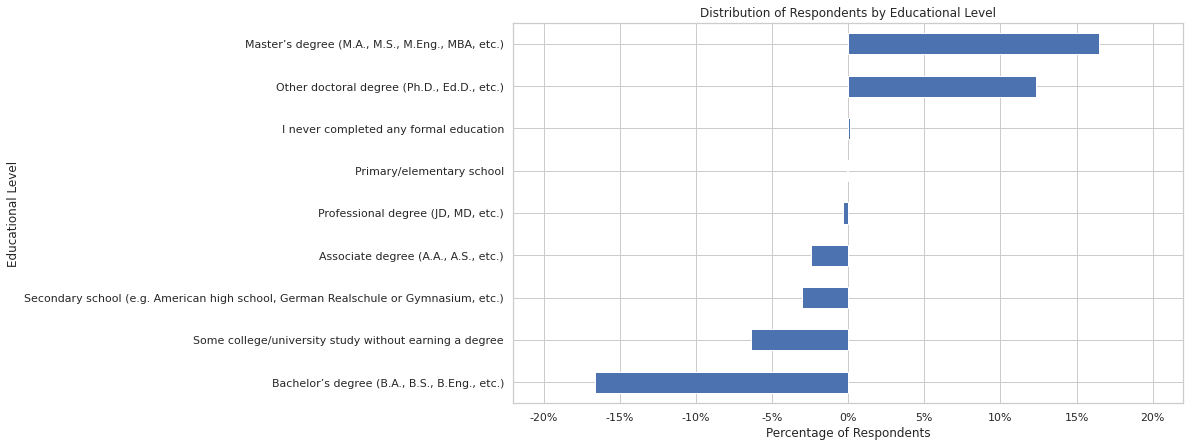

In [11]:
diffs = edlevel_compare['Diff']
ax = diffs.sort_values().plot(kind='barh', figsize=(12,7))
ax.xaxis.set_major_formatter(lambda x, p: f'{x:.0%}')
plt.xlim(-.22, .22)
plt.xlabel('Percentage of Respondents')
plt.ylabel('Educational Level')
plt.title('Distribution of Respondents by Educational Level')
plt.show()

## Technological Competencies

In [12]:
def get_percent_count(data, ds, col, topn):
    
    select = data['DataScience'] if ds else ~data['DataScience']
    
    selected_data = data.loc[select, col]
    n = selected_data.shape[0]
    result = selected_data.str.split(';').explode().value_counts(ascending=True).to_frame('count').tail(topn)
    result['percent'] = result['count'] / n
    result['category'] = col
    result['DataScience'] = ds
    return result

In [13]:
def gen_col_list(worked):
    cols_prefix = ['Database', 'Language', 'MiscTech']
    sufix = 'WorkedWith' if worked else 'DesireNextYear'
    return [prefix + sufix for prefix in cols_prefix]

In [14]:
def tab_tech_comparison(data, worked, topn):    
    col_list = gen_col_list(worked)
    
    data_list = []
    for ds in [True, False]:
        for col in col_list:
            data_list.append(get_percent_count(df, ds, col, topn))
    
    tech_data = pd.concat(data_list).reset_index()
    
    labels = ['Database', 'Language', 'Miscellaneous']
    cat_labeller = {col:label for col, label in zip(col_list, labels)}
    tech_data['category'] = tech_data['category'].map(cat_labeller)
    
    ds_labeller = {True: 'Data Scientist', False: 'Other Developers'}
    tech_data['DataScience'] = tech_data['DataScience'].map(ds_labeller)
    
    return tech_data

In [15]:
def plot_technical_comparison(plot_data, worked=True, topn=5):
    gs = sns.FacetGrid(data=plot_data, col='category', row='DataScience',
                       sharey=False, aspect=1.5, margin_titles=True, height=4)
    gs.map(plt.barh, 'index', 'percent')
    for i, ax in enumerate(gs.axes.flat):
        ax.xaxis.set_major_formatter(lambda x, p: f'{x:.0%}')
        ax.set_ylabel('')
        ax.set_xlim((0,1))
        if i > 2:
            ax.set_xlabel('Percent of Developers')
    gs.set_titles(row_template='{row_name}', col_template='{col_name}')
    gs.fig.subplots_adjust(top=0.87)
    title_complement = 'Worked With' if worked else 'Desired to Work With'
    title = f'Top-{topn} {title_complement} With Tools in 2020 for Data Scientists and Other Developers'
    gs.fig.suptitle(title, fontsize=20)
    plt.show()

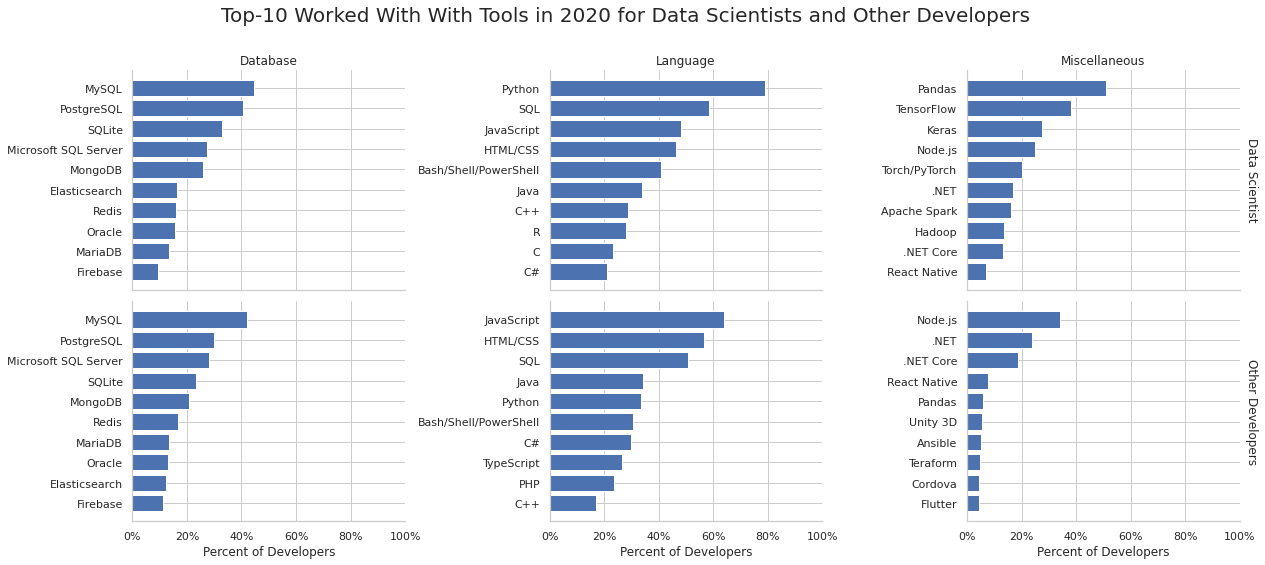

In [16]:
worked = True
topn = 10

worked_comparison = tab_tech_comparison(df, worked, topn)
plot_technical_comparison(worked_comparison, worked, topn)

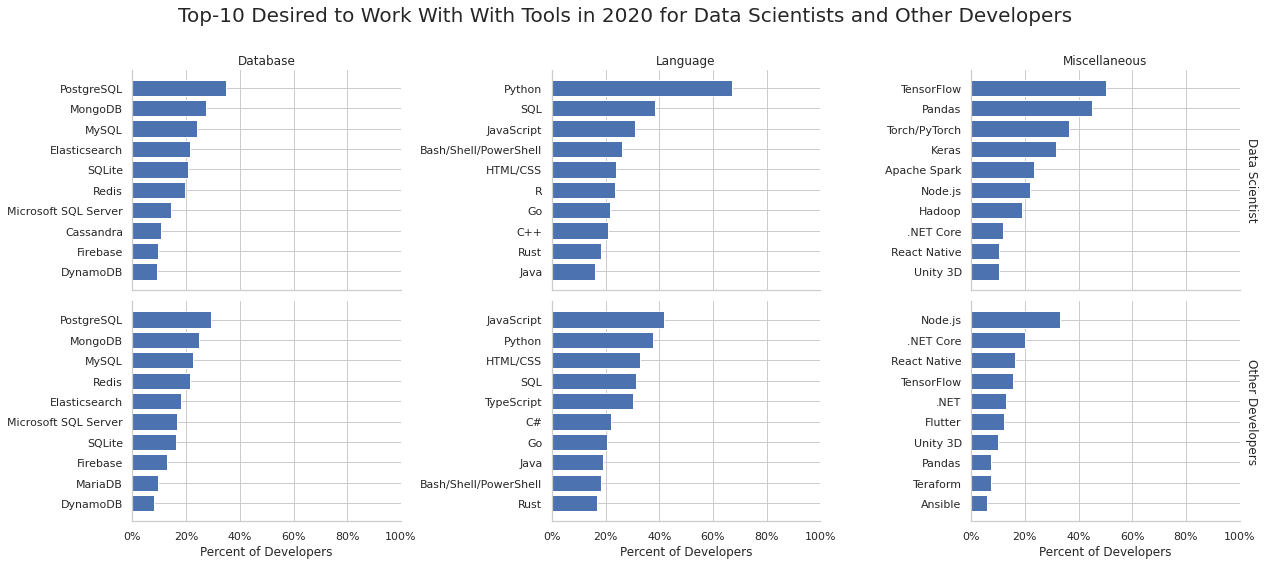

In [17]:
worked = False
topn = 10

desire_comparison = tab_tech_comparison(df, worked, topn)
plot_technical_comparison(desire_comparison, worked, topn)

# Technological Correlations

In [18]:
def cramers_corrected_stat(x, y):
    contigency_tab = pd.crosstab(x, y)
    n = contigency_tab.sum().sum()
    r, k = contigency_tab.shape
    
    chi2 = ss.chi2_contingency(contigency_tab)[0]
    phi2 = chi2/n

    phi2corr = max(0, phi2 - (((k-1)*(r-1))/(n-1)))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min(kcorr-1, rcorr-1))

In [19]:
col0 = tech_cats.columns[0]
col1 = tech_cats.columns[1]
cont = pd.crosstab(tech_cats[col0], tech_cats[col1])
ss.chi2_contingency(cont)[0] / cont.sum().sum()

NameError: name 'tech_cats' is not defined

In [ ]:
desire_tech_cols = df.columns.str.endswith('DesireNextYear')
worked_tech_cols = df.columns.str.endswith('WorkedWith')
tech_cols = df.columns[desire_tech_cols | worked_tech_cols]
tech_df = df[tech_cols].copy()

In [ ]:
def multicategorical_dummy(df, col):
    serie = df[col]#.dropna()
    serie = serie.str.split(';').explode()
    dummies_df = pd.get_dummies(serie).reset_index().groupby('Respondent').max()
    return dummies_df#.std()#sum().div(size).mul(100).round(2)

In [ ]:
multicategorical_dummy(tech_df, tech_df.columns[0])

In [ ]:
def dummy_all(data):
    result = dict()
    for col in data.columns:
        dummies = multicategorical_dummy(data, col)
        result[col] = dummies
    return result
tech_cats = dummy_all(tech_df)
#tech_corr = tech_cats.corr(method=cramers_corrected_stat)

In [ ]:
tech_corr = tech_cats['LanguageWorkedWith'].corr(method=cramers_corrected_stat)
tech_corr

In [ ]:
tech_corr.loc[(tech_corr > .5).sum() > 1 ,(tech_corr > .5).sum() > 1]

In [ ]:
plt.pcolor(tech_cats['LanguageWorkedWith'].corr(method=cramers_corrected_stat));

In [ ]:
plt.figure(figsize=(20, 20))
plt.pcolor(tech_corr);